Тема 6. Прогнозирование временных рядов с помощью алгоритмов Xgboost regression

## 2.1. Описание процесса выбора данных для анализа и методы

В данном разделе рассматривается процесс выбора подходящего набора данных для анализа и описываются методы предварительной обработки данных.

Процесс выбора данных для анализа включает в себя следующие шаги:
1. Определение целей анализа и ключевых вопросов, на которые необходимо ответить.
2. Поиск и оценка доступных наборов данных, которые могут быть использованы для достижения поставленных целей.
3. Выбор наиболее подходящего набора данных, учитывая такие критерии как качество, релевантность, размер и доступность.

Методы предварительной обработки данных:
1. Очистка данных: удаление пропущенных значений, обработка выбросов, устранение дубликатов.
2. Преобразование данных: нормализация, масштабирование, кодирование категориальных признаков.
3. Выбор и построение признаков: создание новых признаков на основе исходных данных, отбор наиболее информативных признаков.
4. Разделение данных на обучающую и тестовую выборки для последующей оценки модели.

Таким образом, в этом разделе проводится тщательный анализ и подготовка данных, чтобы обеспечить высокое качество входных данных для последующего моделирования и анализа.

## 1. Описание данных.

В разделе практики рассматриваются задачи сравнения точности прогнозирования моделей LSTM (Long Short-Term Memory) и XGBoost (Extreme Gradient Boosting).

В качестве набора данных используется датасет Bitcoin USD (BTC-USD), который находится в свободном доступе по адресу https://finance.yahoo.com/quote/BTC-USD/history?p=BTC-USD. Данный датасет содержит цены биткоина с 2015 по 2024 год и включает следующие признаки:

- Date − дата
- Open − цена открытия
- High − максимальная цена
- Low − минимальная цена
- Close − цена закрытия
- Adj Close − скорректированная цена закрытия
- Volume − объем торгов

Датасет представлен в виде объекта `pandas.DataFrame` со следующими характеристиками:

- Количество записей (entries): 3197
- Количество столбцов (columns): 7
- Типы данных: 5 столбцов с `float64`, 1 столбец с `int64`, 1 столбец с `object`
- Общий размер занимаемой памяти: около 175 КБ

Таким образом, мы будем использовать этот датасет для сравнения точности прогнозирования моделей LSTM и XGBoost.

## 2. Установка и импорт необходимых библиотек

На первом этапе необходимо установить необходимые библиотеки для проведения анализа. Для этого используем следующую команду:

In [ ]:
!pip install tensorflow

Далее импортируем все требуемые библиотеки:

In [ ]:
# Основные библиотеки
import os
import pandas as pd
import numpy as np
import math
import datetime as dt

# Библиотеки для оценки модели
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score, mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

# Библиотеки для построения модели
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras.utils import plot_model
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, KFold

# Библиотеки для визуализации
import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Библиотеки для выявления аномалий
from scipy.stats import zscore
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

# Библиотеки для машинного обучения
from sklearn import ensemble, metrics
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from xgboost import plot_importance, plot_tree

# Дополнительные библиотеки
from datetime import datetime

## 3. Загрузка и обработка набора данных

После установки и импорта библиотек, первым шагом является загрузка необходимого набора данных для дальнейшего анализа. В данном случае мы будем работать с данными по биткойну (Bitcoin USD), которые находятся в файле "BTC-USD.csv" в той же директории.

Для загрузки данных используем библиотеку Pandas:

In [ ]:
# Загрузка данных
maindf = pd.read_csv("/content/BTC-USD.csv")

# Вывод информации о загруженном датасете
print('Общее количество дней в датасете: ', maindf.shape[0])
print('Общее количество полей в датасете: ', maindf.shape[1])
print('Вывод формы датафрейма: ')
print(maindf.shape)
print('Вывод первых 5 строк датафрейма:')
print(maindf.head())
print('Вывод последних 5 строк датафрейма:')
print(maindf.tail())
print('Вывод информации о датафрейме:')
print(maindf.info())

Общее количество дней в датасете:  3197
Общее количество полей в датасете:  7
Вывод формы датафрейма: 
(3197, 7)
Вывод первых 5 строк датафрейма:
         Date        Open        High         Low       Close   Adj Close  \
0  2015-07-14  292.033997  296.147003  286.638000  287.463989  287.463989   
1  2015-07-15  288.045013  293.247986  285.367004  285.829010  285.829010   
2  2015-07-16  286.041992  291.183014  275.239990  278.088989  278.088989   
3  2015-07-17  278.091003  280.279999  272.042999  279.471985  279.471985   
4  2015-07-18  279.330994  282.527008  274.075012  274.901001  274.901001   

     Volume  
0  28727200  
1  27486600  
2  49482600  
3  27591400  
4  25187100  
Вывод последних 5 строк датафрейма:
            Date          Open          High           Low         Close  \
3192  2024-04-09  71632.500000  71742.507813  68212.921875  69139.015625   
3193  2024-04-10  69140.242188  71093.429688  67503.562500  70587.882813   
3194  2024-04-11  70575.734375  71256.23437

Как видно из вывода, датасет содержит 3197 записей и 7 столбцов. Обратим внимание, что столбец "Date" имеет тип "object", что не типично для представления даты. Поэтому необходимо преобразовать этот столбец в формат datetime для корректной работы с датами:

In [ ]:
# Преобразование столбца "Date" в формат datetime
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

Далее проверим наличие пропущенных значений в данных:

In [ ]:
# Проверка на наличие пропущенных значений
print('Количество пропущенных значений:', maindf.isnull().values.sum())
print('Есть ли пропущенные значения:', maindf.isnull().values.any())

# Вывод таблицы с количеством и долей пропущенных значений
missing_values = maindf.isnull().sum()
missing_per = (missing_values/maindf.shape[0])*100
missing_table = pd.concat([missing_values,missing_per], axis=1, ignore_index=True)
missing_table.rename(columns={0:'Общее количество пропущенных', 1:'Доля пропущенных, %'}, inplace=True)
print(missing_table)

Количество пропущенных значений: 0
Есть ли пропущенные значения: False
           Общее количество пропущенных  Доля пропущенных, %
Date                                  0                  0.0
Open                                  0                  0.0
High                                  0                  0.0
Low                                   0                  0.0
Close                                 0                  0.0
Adj Close                             0                  0.0
Volume                                0                  0.0


Как видно из вывода, в данных отсутствуют пропущенные значения. В случае их присутствия для их заполнения можно использовать интерполяцию:

In [ ]:
# Функция для заполнения пропущенных значений с помощью интерполяции
def fill_missing(df):
    df['Low'] = df['Low'].interpolate()
    df['High'] = df['High'].interpolate()
    df['Open'] = df['Open'].interpolate()
    df['Close'] = df['Close'].interpolate()
    df['Adj Close'] = df['Adj Close'].interpolate()
    df['Volume'] = df['Volume'].interpolate()
    print(df.head())
    print(df.isnull().sum())

# Применение функции для заполнения пропущенных значений
fill_missing(maindf)

        Date        Open        High         Low       Close   Adj Close  \
0 2015-07-14  292.033997  296.147003  286.638000  287.463989  287.463989   
1 2015-07-15  288.045013  293.247986  285.367004  285.829010  285.829010   
2 2015-07-16  286.041992  291.183014  275.239990  278.088989  278.088989   
3 2015-07-17  278.091003  280.279999  272.042999  279.471985  279.471985   
4 2015-07-18  279.330994  282.527008  274.075012  274.901001  274.901001   

     Volume  
0  28727200  
1  27486600  
2  49482600  
3  27591400  
4  25187100  
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


После загрузки и удаления пропущенных значений, можно приступить к визуализации данных:


<Axes: title={'center': 'Bitcoin Closing Price'}, xlabel='Date'>

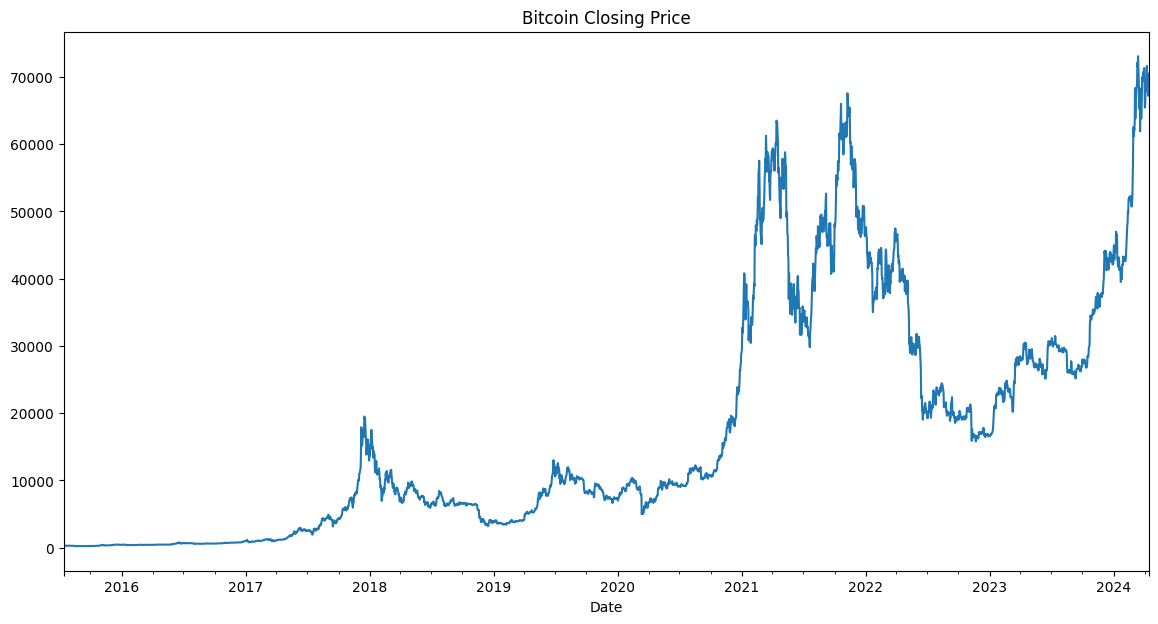

In [ ]:
maindf.set_index("Date")['Adj Close'].plot(figsize=(14,7), title="Bitcoin Closing Price")

Чтобы визуализировать данные:

1. Установили индекс DataFrame на столбец "Date" с помощью `set_index("Date")`.
2. Выбрали столбец "Adj Close" для построения графика.
3. Использовали метод `plot()` для построения графика с указанным размером фигуры `figsize=(14,7)` и заголовком `"Bitcoin Closing Price"`.

Таким образом, получили визуальное представление цен закрытия Bitcoin за исследуемый период.

### Выявление и удаление выбросов

**Выявление выбросов:**

- Визуализация данных: Построение графиков и диаграмм может помочь визуально идентифицировать выбросы.
- Использование статистических методов: Расчет и анализ метрик, таких как среднее, стандартное отклонение, квартили и межквартильный размах, позволит выявить аномальные значения.

**Удаление выбросов:**

- Замена выбросов: Заменить выбросы на пропущенные значения или на значения, вычисленные на основе других столбцов.
- Удаление строк с выбросами: Удалить полностью строки, содержащие выбросы, если их небольшое количество и они не окажут существенного влияния на дальнейший анализ.
- Применение робастных методов: Использовать методы, устойчивые к выбросам, например, медиану вместо среднего или регрессию, основанную на медиане.

**Выявление выбросов:**

Визуализация данных: Построение графиков и диаграмм может помочь визуально идентифицировать выбросы.

- Построение диаграммы рассеяния (scatter plot):

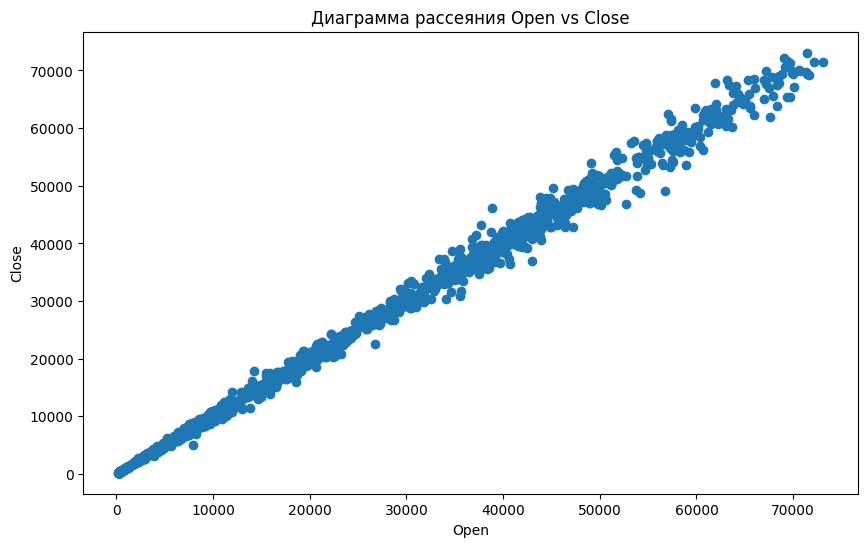

In [ ]:
import matplotlib.pyplot as plt

# Построение диаграммы рассеяния для двух столбцов
plt.figure(figsize=(10, 6))
plt.scatter(maindf['Open'], maindf['Close'])
plt.xlabel('Open')
plt.ylabel('Close')
plt.title('Диаграмма рассеяния Open vs Close')
plt.show()

Данный график позволит визуально идентифицировать аномальные значения, выделяющиеся от основного скопления точек.

- Построение боксплота (box plot):

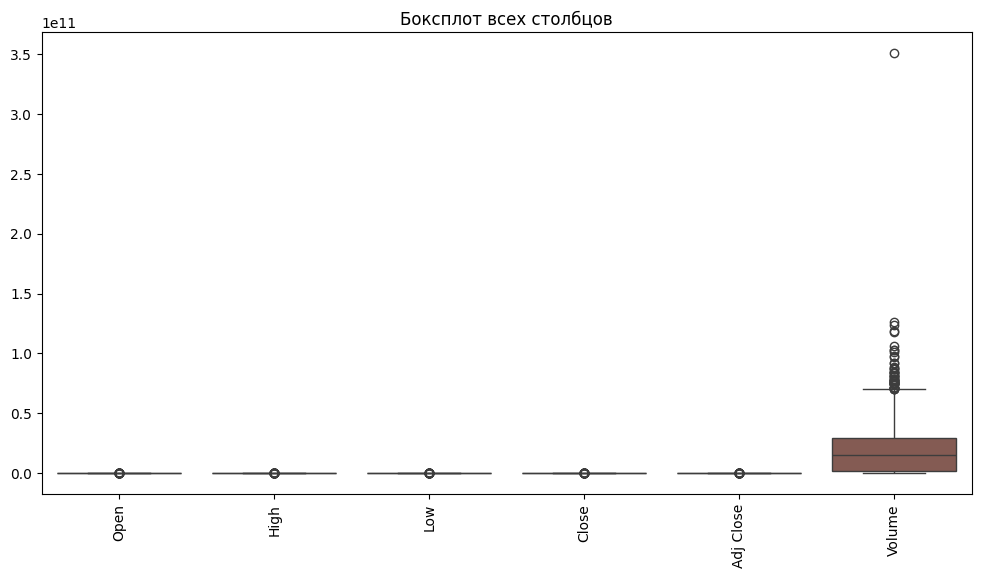

In [ ]:
import seaborn as sns

# Построение боксплота для каждого столбца
plt.figure(figsize=(12, 6))
sns.boxplot(data=maindf)
plt.xticks(rotation=90)
plt.title('Боксплот всех столбцов')
plt.show()

Боксплот наглядно показывает распределение данных, выявляя возможные выбросы в виде точек за пределами "усов" графика.

-Построение гистограммы (histogram):

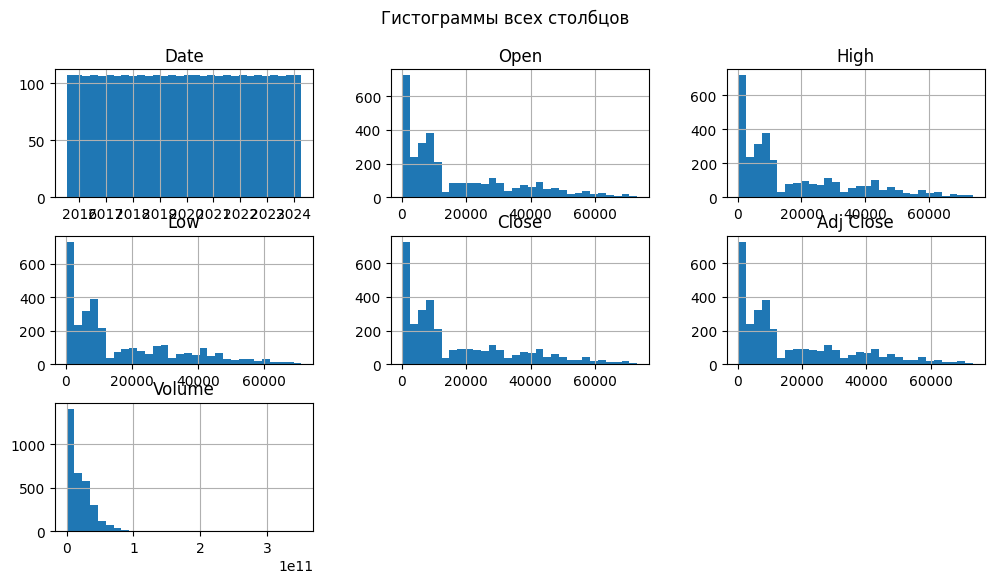

In [ ]:
# Построение гистограммы для каждого столбца
maindf.hist(figsize=(12, 6), bins=30)
plt.suptitle('Гистограммы всех столбцов')
plt.show()

- Использование статистических методов

1. Расчет средних значений и стандартного отклонения:

In [ ]:
print(f"Среднее значение:\n{maindf.mean()}")
print(f"Стандартное отклонение:\n{maindf.std()}")

Среднее значение:
Date         2019-11-28 00:00:00
Open                17234.515073
High                17638.235947
Low                 16805.813669
Close               17254.207426
Adj Close           17254.207426
Volume        18676355046.704411
dtype: object
Стандартное отклонение:
Date         923 days 00:55:46.408661040
Open                        17605.052417
High                        18030.330417
Low                         17141.094999
Close                       17622.473481
Adj Close                   17622.473481
Volume                19403262165.464279
dtype: object


2. Расчет квартилей и межквартильного размаха (IQR):

In [ ]:
Q1 = maindf[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].quantile(0.25)
Q3 = maindf[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].quantile(0.75)
IQR = Q3 - Q1
print(f"Первый квартиль (Q1):\n{Q1}")
print(f"Третий квартиль (Q3):\n{Q3}")
print(f"Межквартильный размах (IQR):\n{IQR}")

Первый квартиль (Q1):
Open         3.631170e+03
High         3.685306e+03
Low          3.585060e+03
Close        3.631040e+03
Adj Close    3.631040e+03
Volume       1.976040e+09
Name: 0.25, dtype: float64
Третий квартиль (Q3):
Open         2.808718e+04
High         2.853283e+04
Low          2.756388e+04
Close        2.816809e+04
Adj Close    2.816809e+04
Volume       2.924455e+10
Name: 0.75, dtype: float64
Межквартильный размах (IQR):
Open         2.445601e+04
High         2.484752e+04
Low          2.397882e+04
Close        2.453705e+04
Adj Close    2.453705e+04
Volume       2.726851e+10
dtype: float64


Значения, находящиеся за пределами диапазона [Q1 - 1.5 * IQR, Q3 + 1.5 * IQR], могут считаться выбросами.

In [ ]:
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(f"Нижняя граница выбросов: {lower_bound}")
print(f"Верхняя граница выбросов: {upper_bound}")

Нижняя граница выбросов: Open        -3.305284e+04
High        -3.358598e+04
Low         -3.238317e+04
Close       -3.317453e+04
Adj Close   -3.317453e+04
Volume      -3.892673e+10
dtype: float64
Верхняя граница выбросов: Open         6.477118e+04
High         6.580412e+04
Low          6.353210e+04
Close        6.497366e+04
Adj Close    6.497366e+04
Volume       7.014732e+10
dtype: float64


Чтобы работать с выбросами и удалить их необходимо провести идентификация выбросов: т.е необходимо определить, какие значения в данных лежат вне этого диапазона, и считать их выбросами.

In [ ]:
outlier_mask = (
    (maindf[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']] < lower_bound).any(axis=1) |
    (maindf[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']] > upper_bound).any(axis=1)
)
outlier_indices = np.where(outlier_mask)[0]

print(f"Индексы выбросов: {outlier_indices}")

Индексы выбросов: [1704 1909 1983 2000 2001 2003 2004 2005 2007 2008 2009 2018 2019 2025
 2026 2034 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2050 2051
 2054 2080 2094 2101 2103 2105 2109 2110 2127 2129 2130 2134 2136 2137
 2138 2140 2290 2291 2309 2310 2311 2312 2313 2315 2316 2369 2493 2674
 2675 2676 3151 3156 3157 3158 3159 3160 3161 3162 3163 3164 3165 3166
 3167 3168 3169 3170 3171 3172 3173 3174 3175 3176 3177 3178 3179 3180
 3181 3182 3183 3184 3185 3186 3187 3188 3189 3190 3191 3192 3193 3194
 3195 3196]


Использование робастных методов (например, медиана вместо среднего):

In [ ]:
maindf1 = maindf[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].median()

3. Идентификация выбросов с использованием Z-score:

In [ ]:
# Применение Z-score к числовым столбцам
z = np.abs(zscore(maindf[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]))

# Определение маски выбросов
outlier_mask = (z > 3).any(axis=1)
outlier_indices = maindf.index[outlier_mask]

print(f"Индексы выбросов: {outlier_indices}")

Индексы выбросов: Index([2000, 2001, 2004, 2005, 2007, 2008, 2019, 2026, 2036, 2037, 2038, 2039,
       2043, 2044, 2045, 2050, 2051, 2054, 2101, 2103, 2105, 2110, 2130, 2136,
       2137, 2138, 2140, 2369, 2674, 2675, 2676, 3151, 3157, 3162, 3163, 3164,
       3165, 3166, 3167, 3178, 3179, 3180, 3181, 3182, 3183, 3184, 3190, 3191,
       3192, 3193, 3194, 3195],
      dtype='int64')


Значения с абсолютным Z-score, превышающим 3, обычно считаются выбросами.



Удаляем строки, содержащие выбросы, определенные с помощью Z-score

In [ ]:
# Удаляем строки, содержащие выбросы, определенные с помощью Z-score
#maindf = maindf.loc[~outlier_mask]

4. Метод локального выброса (LOF - Local Outlier Factor):

In [ ]:
# Применение LOF к числовым столбцам
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
y_pred = lof.fit_predict(maindf[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']])

# Определение индексов выбросов (-1 - выброс, 1 - не выброс)
outlier_indices = np.where(y_pred == -1)[0]

print(f"Индексы выбросов (LOF): {outlier_indices}")

Индексы выбросов (LOF): [   5   12   67   68   74   75   82   88  468  486  489  767  938 1522
 2005 2008 2026 2036 2037 2038 2050 2051 2054 2105 2130 2136 2137 2674
 2675 2856 2953 3157]


Удаление выбросов, определенных с помощью LOF:

In [ ]:
# Удаляем строки с выбросами, определенными с помощью LOF
#maindf = maindf.loc[~maindf.index.isin(outlier_indices)]

5. Метод изолирующего леса (Isolation Forest):

In [ ]:
# Применение Isolation Forest к числовым столбцам
iso_forest = IsolationForest(contamination=0.01)
y_pred = iso_forest.fit_predict(maindf[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']])

# Определение индексов выбросов (-1 - выброс, 1 - не выброс)
outlier_indices = np.where(y_pred == -1)[0]

print(f"Индексы выбросов (Isolation Forest): {outlier_indices}")

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Индексы выбросов (Isolation Forest): [2310 3156 3157 3158 3160 3161 3162 3163 3164 3165 3166 3167 3169 3170
 3171 3172 3177 3178 3179 3180 3181 3182 3183 3184 3189 3190 3191 3192
 3193 3194 3195 3196]


Удаление выбросов, определенных с помощью Isolation Forest:

In [ ]:
# Удаляем строки с выбросами, определенными с помощью LOF
maindf = maindf.loc[~maindf.index.isin(outlier_indices)]

### Анализ по годам

In [ ]:
# Printing the start date and End date of the dataset

sd=maindf.iloc[0][0]
ed=maindf.iloc[-1][0]


print('Starting Date',sd)
print('Ending Date',ed)


Starting Date 2015-07-14 00:00:00
Ending Date 2024-04-05 00:00:00


Следующим шагом будет анализ данных по годам, начиная с 2015 года.

#### Анализ данных за 2015 год

В ходе исследования первоначальный столбец "Date" будет преобразован в формат datetime с помощью функции pd.to_datetime(). Далее, из исходного DataFrame будет выделено подмножество данных, соответствующих 2015 году, с использованием срезов maindf.loc[(maindf['Date'] >= '2015-01-01') & (maindf['Date'] < '2015-12-31')]. Для последующего анализа будут удалены столбцы "Adj Close" и "Volume", как не представляющие интереса в рамках текущего исследования.

In [ ]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_2015 = maindf.loc[(maindf['Date'] >= '2015-01-01')
                     & (maindf['Date'] < '2015-12-31')]

y_2015.drop(y_2015[['Adj Close','Volume']],axis=1)

<ipython-input-23-cc88948aa1bf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')


,Date,Open,High,Low,Close
0,2015-07-14,292.033997,296.147003,286.638000,287.463989
1,2015-07-15,288.045013,293.247986,285.367004,285.829010
2,2015-07-16,286.041992,291.183014,275.239990,278.088989
3,2015-07-17,278.091003,280.279999,272.042999,279.471985
4,2015-07-18,279.330994,282.527008,274.075012,274.901001
...,...,...,...,...,...
165,2015-12-26,455.756012,457.489014,405.760010,417.273987
166,2015-12-27,416.514008,424.006989,408.882996,422.822998
167,2015-12-28,423.342987,429.769012,418.480988,422.278992
168,2015-12-29,422.097992,432.983002,420.627014,432.983002


Далее, мы рассчитали среднюю открывающую и закрывающую цену по месяцам с помощью y_2015.groupby(y_2015['Date'].dt.strftime('%B'))[['Open','Close']].mean(). Для корректного порядка месяцев мы использовали new_order и метод reindex().

In [ ]:
monthvise= y_2015.groupby(y_2015['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,NaN,NaN
February,NaN,NaN
March,NaN,NaN
April,NaN,NaN
May,NaN,NaN
June,NaN,NaN
July,284.114058,283.729331
August,252.986774,250.733805
September,233.486733,233.595533


Следующим шагом было визуализировать помесячное сравнение открывающей и закрывающей цен с помощью библиотеки Plotly:

In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45,
                  title='Monthwise comparision between Stock open and close price')
fig.show()

Этот код использует библиотеку Plotly для создания визуализации данных в виде гистограммы. Вот более подробное объяснение каждой строки кода:

1. `fig = go.Figure()`: Создает новый объект Figure, который будет содержать все элементы графика.

2. ```python
   fig.add_trace(go.Bar(
       x=monthvise.index,
       y=monthvise['Open'],
       name='Stock Open Price',
       marker_color='crimson'
   ))
   ```
   Добавляет к графику первый набор данных - гистограмму, отображающую значения открытия акций (`monthvise['Open']`) по месяцам (`monthvise.index`). Цвет столбцов - "crimson".

3. ```python
   fig.add_trace(go.Bar(
       x=monthvise.index,
       y=monthvise['Close'],
       name='Stock Close Price',
       marker_color='lightsalmon'
   ))
   ```
   Добавляет к графику второй набор данных - гистограмму, отображающую значения закрытия акций (`monthvise['Close']`) по месяцам (`monthvise.index`). Цвет столбцов - "lightsalmon".

4. `fig.update_layout(barmode='group', xaxis_tickangle=-45, title='Monthwise comparision between Stock open and close price')`: Настраивает макет графика:
   - `barmode='group'`: располагает гистограммы рядом друг с другом
   - `xaxis_tickangle=-45`: располагает подписи на оси X под углом -45 градусов
   - `title='Monthwise comparision between Stock open and close price'`: устанавливает заголовок графика

5. `fig.show()`: Отображает график.

Таким образом, этот код создает гистограмму, которая сравнивает месячную динамику цен открытия и закрытия акций.



Учитывая, что у нас есть данные только за несколько месяцев 2015 года, остальные месяцы будут содержать значения NaN, давайте визуализируем полученные данные.

Также мы вычислим максимальные и минимальные цены по месяцам и визуализировали их:

In [ ]:
y_2015.groupby(y_2015['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2015.groupby(maindf['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2015.groupby(y_2015['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group',
                  title=' Monthwise High and Low stock price')
fig.show()

Полученный график позволяет наглядно увидеть помесячную динамику средних цен открытия и закрытия акций в 2015 году. Обратите внимание, что для месяцев, по которым нет данных, значения отображаются как NaN.

Наконец, мы построим линейный график, отображающий динамику открывающей, закрывающей, максимальной и минимальной цен за 2015 год:

In [ ]:
names = cycle(['Цена открытия акций', 'Цена закрытия акций', 'Максимальная цена акций', 'Минимальная цена акций'])

fig = px.line(y_2015, x=y_2015.Date, y=[y_2015['Open'], y_2015['Close'],
y_2015['High'], y_2015['Low']],
labels={'Date': 'Дата','value':'Значение акций'})
fig.update_layout(title_text='График анализа акций', font_size=15, font_color='black',legend_title_text='Параметры акций')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()


# Анализ 2016 года

Аналогично образу 2015 года, анализируем 2016 год.

In [ ]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_2016 = maindf.loc[(maindf['Date'] >= '2016-01-01')
                     & (maindf['Date'] < '2016-12-31')]

y_2016.drop(y_2016[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
171,2016-01-01,430.721008,436.246002,427.515015,434.334015
172,2016-01-02,434.622009,436.062012,431.869995,433.437988
173,2016-01-03,433.578003,433.743011,424.705994,430.010986
174,2016-01-04,430.061005,434.516998,429.084015,433.091003
175,2016-01-05,433.069000,434.182007,429.675995,431.959991
...,...,...,...,...,...
531,2016-12-26,896.905029,913.184021,896.898010,907.609985
532,2016-12-27,908.354004,940.047974,904.255005,933.197998
533,2016-12-28,934.830994,975.921021,934.830994,975.921021
534,2016-12-29,975.125000,979.396973,954.502991,973.497009


Данный код выделяет данные за 2016 год из основного датасета maindf. Он преобразует столбец 'Date' в формат datetime, а затем фильтрует строки, где дата находится в диапазоне с 1 января 2016 по 31 декабря 2016. После этого он удаляет столбцы 'Adj Close' и 'Volume' из полученного датафрейма y_2016.

Теперь можно провести более детальный анализ данных за 2016 год, используя оставшиеся столбцы. Это позволит выявить ключевые тенденции и показатели, характерные для этого периода.

Далее, для улучшения читаемости, он упорядочивает месяцы в правильном хронологическом порядке, используя список new_order.


In [ ]:
monthvise= y_2016.groupby(y_2016['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,412.805902,410.844485
February,402.304692,404.408274
March,417.262033,416.525774
April,433.487433,434.339398
May,459.237547,461.954415
June,638.544834,642.869061
July,662.977779,661.356103
August,581.238966,579.585197
September,604.614034,605.848633


Теперь можно более детально проанализировать динамику средних открытия и закрытия цен по месяцам в 2016 году.

In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45,
                  title='Monthwise comparision between Stock open and close price')
fig.show()

Этот код использует библиотеку Plotly для создания визуализации в виде двух сгруппированных столбчатых диаграмм, отображающих среднемесячные цены открытия и закрытия акций.

Приведем более подробное объяснение:

1. `fig = go.Figure()` - создает новый объект `Figure` из модуля `plotly.graph_objects` (go), который будет использоваться для построения графика.

2. `fig.add_trace(go.Bar())` - добавляет на график новый след (trace) в виде столбчатой диаграммы. Для каждого показателя (открытие и закрытие) создается отдельный след.
   - `x=monthvise.index` - устанавливает месяцы в качестве значений по оси X.
   - `y=monthvise['Open']` и `y=monthvise['Close']` - устанавливает значения по оси Y из соответствующих столбцов датафрейма `monthvise`.
   - `name='Stock Open Price'` и `name='Stock Close Price'` - задает названия легенды для каждого следа.
   - `marker_color='crimson'` и `marker_color='lightsalmon'` - устанавливает цвет столбцов для каждого следа.

3. `fig.update_layout()` - настраивает общее оформление графика:
   - `barmode='group'` - отображает столбчатую диаграмму в сгруппированном режиме.
   - `xaxis_tickangle=-45` - поворачивает подписи на оси X на 45 градусов.
   - `title='Monthwise comparision between Stock open and close price'` - задает заголовок графика.

4. `fig.show()` - отображает построенный график.

В результате получается визуализация, на которой можно наблюдать помесячную динамику средних цен открытия и закрытия акций в 2016 году.

Теперь вычисляем максимальные и минимальные цены за месяц и визуализируем цены акций в 2016 году.

In [ ]:
y_2016.groupby(y_2016['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2016.groupby(maindf['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2016.groupby(y_2016['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group',
                  title=' Monthwise High and Low stock price')
fig.show()

Этот код выполняет следующие действия:

1. `y_2016.groupby(y_2016['Date'].dt.strftime('%B'))['Low'].min()`:
   - Группирует данные из датафрейма `y_2016` по месяцам, используя `dt.strftime('%B')` для извлечения месяца из столбца `'Date'`.
   - Внутри каждой группы (месяца) вычисляет минимальное значение столбца `'Low'`.
   - Результатом является серия, содержащая минимальные значения низких цен по месяцам.

2. `monthvise_high = y_2016.groupby(maindf['Date'].dt.strftime('%B'))['High'].max()`:
   - Группирует данные из основного датафрейма `maindf` по месяцам, используя `dt.strftime('%B')` для извлечения месяца из столбца `'Date'`.
   - Внутри каждой группы (месяца) вычисляет максимальное значение столбца `'High'`.
   - Результатом является серия, содержащая максимальные значения высоких цен по месяцам.

3. `monthvise_high = monthvise_high.reindex(new_order, axis=0)`:
   - Перераспределяет порядок месяцев в серии `monthvise_high` в соответствии с заданным порядком в списке `new_order`.

4. `monthvise_low = y_2016.groupby(y_2016['Date'].dt.strftime('%B'))['Low'].min()`:
   - Аналогично первому пункту, но вычисляет минимальные значения низких цен по месяцам для датафрейма `y_2016`.

5. `monthvise_low = monthvise_low.reindex(new_order, axis=0)`:
   - Перераспределяет порядок месяцев в серии `monthvise_low` в соответствии с заданным порядком в списке `new_order`.

6. Построение графика с использованием библиотеки Plotly:
   - Создается новый объект `Figure`.
   - Добавляются два следа:
     - Первый след для максимальных цен (`monthvise_high`) с синим цветом.
     - Второй след для минимальных цен (`monthvise_low`) с оранжевым цветом.
   - Устанавливается групповой режим отображения столбчатой диаграммы (`barmode='group'`).
   - Задается заголовок графика.
   - Вызывается `fig.show()` для отображения построенного графика.

Таким образом, этот код вычисляет и визуализирует помесячные максимальные и минимальные цены акций в 2016 году.

Note that we only have few months in 2016 so the rest of the months are not plotted since we do not have the data

In [ ]:
names = cycle(['Цена открытия акций', 'Цена закрытия акций', 'Максимальная цена акций', 'Минимальная цена акций'])

fig = px.line(y_2016, x=y_2016.Date, y=[y_2016['Open'], y_2016['Close'],
y_2016['High'], y_2016['Low']],
labels={'Date': 'Дата','value':'Значение акций'})
fig.update_layout(title_text='График анализа акций', font_size=15, font_color='black',legend_title_text='Параметры акций')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

# Analysis of Year 2017

In [ ]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_2017 = maindf.loc[(maindf['Date'] >= '2017-01-01')
                     & (maindf['Date'] < '2017-12-31')]

y_2017 = y_2017.drop(['Adj Close', 'Volume'], axis=1)

In [ ]:
monthvise= y_2017.groupby(y_2017['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,914.680971,914.916159
February,1055.620071,1062.533672
March,1133.212576,1129.365228
April,1197.646997,1206.641007
May,1865.748712,1895.383529
June,2630.573332,2636.204346
July,2509.213233,2519.418386
August,3819.812579,3880.989998
September,4077.400993,4064.836312


In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45,
                  title='Monthwise comparision between Stock open and close price')
fig.show()

In [ ]:
y_2017.groupby(y_2017['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2017.groupby(maindf['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2017.groupby(y_2017['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group',
                  title=' Monthwise High and Low stock price')
fig.show()

In [ ]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(y_2017, x=y_2017.Date, y=[y_2017['Open'], y_2017['Close'],
                                          y_2017['High'], y_2017['Low']],
             labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

# Analysis of Year 2018

In [ ]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_2018 = maindf.loc[(maindf['Date'] >= '2018-01-01') & (maindf['Date'] < '2018-12-31')]

y_2018.drop(y_2018[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
902,2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195
903,2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609
904,2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000
905,2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195
906,2018-01-05,15477.200195,17705.199219,15202.799805,17429.500000
...,...,...,...,...,...
1261,2018-12-26,3819.666748,3893.359619,3769.863770,3857.297607
1262,2018-12-27,3854.688477,3874.416992,3645.448486,3654.833496
1263,2018-12-28,3653.131836,3956.135986,3642.632080,3923.918701
1264,2018-12-29,3932.491699,3963.758789,3820.408691,3820.408691


In [ ]:
monthvise= y_2018.groupby(y_2018['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,13212.074219,13085.558090
February,9462.242920,9472.001151
March,9156.591718,9040.557097
April,7963.618311,8033.596631
May,8505.240675,8450.997732
June,6829.257975,6793.507666
July,7101.466450,7146.349987
August,6723.800955,6700.129946
September,6622.821338,6610.675033


In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45,
                  title='Monthwise comparision between Stock open and close price')
fig.show()

In [ ]:
y_2018.groupby(y_2018['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2018.groupby(maindf['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2018.groupby(y_2018['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group',
                  title=' Monthwise High and Low stock price')
fig.show()

In [ ]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(y_2018, x=y_2018.Date, y=[y_2018['Open'], y_2018['Close'],
                                          y_2018['High'], y_2018['Low']],
             labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

# Analysis of Year 2019

In [ ]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_2019 = maindf.loc[(maindf['Date'] >= '2019-01-01') & (maindf['Date'] < '2019-12-31')]

y_2019.drop(y_2019[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
1267,2019-01-01,3746.713379,3850.913818,3707.231201,3843.520020
1268,2019-01-02,3849.216309,3947.981201,3817.409424,3943.409424
1269,2019-01-03,3931.048584,3935.685059,3826.222900,3836.741211
1270,2019-01-04,3832.040039,3865.934570,3783.853760,3857.717529
1271,2019-01-05,3851.973877,3904.903076,3836.900146,3845.194580
...,...,...,...,...,...
1626,2019-12-26,7274.799316,7388.302734,7200.386719,7238.966797
1627,2019-12-27,7238.141113,7363.529297,7189.934082,7290.088379
1628,2019-12-28,7289.031250,7399.041016,7286.905273,7317.990234
1629,2019-12-29,7317.647461,7513.948242,7279.865234,7422.652832


In [ ]:
monthvise= y_2019.groupby(y_2019['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,3709.705645,3701.554963
February,3697.178327,3711.907261
March,3967.740400,3976.069100
April,5136.813314,5178.469434
May,7205.208024,7309.694131
June,9339.480322,9415.900179
July,10691.706055,10669.336158
August,10657.745621,10643.248362
September,9858.141813,9814.067871


In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45,
                  title='Monthwise comparision between Stock open and close price')
fig.show()

In [ ]:
y_2019.groupby(y_2019['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2019.groupby(maindf['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2019.groupby(y_2019['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group',
                  title=' Monthwise High and Low stock price')
fig.show()

In [ ]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(y_2019, x=y_2019.Date, y=[y_2019['Open'], y_2019['Close'],
                                          y_2019['High'], y_2019['Low']],
             labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

# Analysis of Year 2020

In [ ]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_2020 = maindf.loc[(maindf['Date'] >= '2020-01-01') & (maindf['Date'] < '2020-12-31')]

y_2020.drop(y_2020[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
1632,2020-01-01,7194.892090,7254.330566,7174.944336,7200.174316
1633,2020-01-02,7202.551270,7212.155273,6935.270020,6985.470215
1634,2020-01-03,6984.428711,7413.715332,6914.996094,7344.884277
1635,2020-01-04,7345.375488,7427.385742,7309.514160,7410.656738
1636,2020-01-05,7410.451660,7544.497070,7400.535645,7411.317383
...,...,...,...,...,...
1992,2020-12-26,24677.015625,26718.070313,24522.689453,26437.037109
1993,2020-12-27,26439.373047,28288.839844,25922.769531,26272.294922
1994,2020-12-28,26280.822266,27389.111328,26207.640625,27084.808594
1995,2020-12-29,27081.810547,27370.720703,25987.298828,27362.437500


In [ ]:
monthvise= y_2020.groupby(y_2020['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,8318.949597,8389.270476
February,9656.215113,9630.722185
March,6943.507009,6871.016113
April,7150.611328,7224.477328
May,9237.761530,9263.151745
June,9499.797005,9489.227214
July,9519.383852,9589.899729
August,11639.097215,11652.394185
September,10689.700163,10660.276856


In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45,
                  title='Monthwise comparision between Stock open and close price')
fig.show()

In [ ]:
y_2020.groupby(y_2020['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2020.groupby(maindf['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2020.groupby(y_2020['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group',
                  title=' Monthwise High and Low stock price')
fig.show()

In [ ]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(y_2020, x=y_2020.Date, y=[y_2020['Open'], y_2020['Close'],
                                          y_2020['High'], y_2020['Low']],
             labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

# Analysis of Year 2021

In [ ]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_2021 = maindf.loc[(maindf['Date'] >= '2021-01-01') & (maindf['Date'] < '2021-12-31')]

y_2021.drop(y_2021[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
1998,2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344
1999,2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578
2000,2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438
2001,2021-01-04,32810.949219,33440.218750,28722.755859,31971.914063
2002,2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688
...,...,...,...,...,...
2357,2021-12-26,50428.691406,51196.378906,49623.105469,50809.515625
2358,2021-12-27,50802.609375,51956.328125,50499.468750,50640.417969
2359,2021-12-28,50679.859375,50679.859375,47414.210938,47588.855469
2360,2021-12-29,47623.871094,48119.742188,46201.496094,46444.710938


In [ ]:
monthvise= y_2021.groupby(y_2021['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,34652.961694,34761.649950
February,45874.967216,46306.798968
March,54544.678176,54998.008695
April,57251.256250,57206.720052
May,47105.828503,46443.286668
June,35920.546940,35845.154688
July,34234.212450,34444.973790
August,45516.119834,45709.022682
September,46041.859375,45939.771484


In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45,
                  title='Monthwise comparision between Stock open and close price')
fig.show()

In [ ]:
y_2021.groupby(y_2021['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2021.groupby(maindf['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2021.groupby(y_2021['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group',
                  title=' Monthwise High and Low stock price')
fig.show()

In [ ]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(y_2021, x=y_2021.Date, y=[y_2021['Open'], y_2021['Close'],
                                          y_2021['High'], y_2021['Low']],
             labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

# Analysis of Year 2022

In [ ]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_2022 = maindf.loc[(maindf['Date'] >= '2022-01-01') & (maindf['Date'] < '2022-12-31')]

y_2022.drop(y_2022[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
2363,2022-01-01,46311.746094,47827.312500,46288.484375,47686.812500
2364,2022-01-02,47680.925781,47881.406250,46856.937500,47345.218750
2365,2022-01-03,47343.542969,47510.726563,45835.964844,46458.117188
2366,2022-01-04,46458.851563,47406.546875,45752.464844,45897.574219
2367,2022-01-05,45899.359375,46929.046875,42798.222656,43569.003906
...,...,...,...,...,...
2722,2022-12-26,16842.250000,16920.123047,16812.369141,16919.804688
2723,2022-12-27,16919.291016,16959.845703,16642.072266,16717.173828
2724,2022-12-28,16716.400391,16768.169922,16497.556641,16552.572266
2725,2022-12-29,16552.322266,16651.755859,16508.683594,16642.341797


In [ ]:
monthvise= y_2022.groupby(y_2022['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,41368.073463,41114.422379
February,40591.103934,40763.474051
March,41889.148438,41966.237525
April,41694.653646,41435.319662
May,31900.711127,31706.105217
June,24783.338477,24383.685482
July,21424.733052,21539.253843
August,22471.866557,22366.266318
September,19821.353711,19804.779232


In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45,
                  title='Monthwise comparision between Stock open and close price')
fig.show()

In [ ]:
y_2022.groupby(y_2022['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2022.groupby(maindf['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2022.groupby(y_2022['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group',
                  title=' Monthwise High and Low stock price')
fig.show()

In [ ]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(y_2022, x=y_2022.Date, y=[y_2022['Open'], y_2022['Close'],
                                          y_2022['High'], y_2022['Low']],
             labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

# Analysis of Year 2023

In [ ]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_2023 = maindf.loc[(maindf['Date'] >= '2023-01-01') & (maindf['Date'] < '2023-12-31')]

y_2023.drop(y_2023[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
2728,2023-01-01,16547.914063,16630.439453,16521.234375,16625.080078
2729,2023-01-02,16625.509766,16759.343750,16572.228516,16688.470703
2730,2023-01-03,16688.847656,16760.447266,16622.371094,16679.857422
2731,2023-01-04,16680.205078,16964.585938,16667.763672,16863.238281
2732,2023-01-05,16863.472656,16884.021484,16790.283203,16836.736328
...,...,...,...,...,...
3087,2023-12-26,43599.847656,43603.175781,41676.488281,42520.402344
3088,2023-12-27,42518.468750,43683.160156,42167.582031,43442.855469
3089,2023-12-28,43468.199219,43804.781250,42318.550781,42627.855469
3090,2023-12-29,42614.644531,43124.324219,41424.062500,42099.402344


In [ ]:
monthvise= y_2023.groupby(y_2023['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,20043.860131,20250.717490
February,23304.086007,23304.539202
March,24945.340411,25116.900895
April,28823.841732,28857.574544
May,27562.723160,27499.307145
June,27651.926758,27763.198438
July,30098.767578,30057.469947
August,27959.756615,27852.792843
September,26271.268229,26306.136393


#### Since we had data till 24-08-2021 in Months after August its showing NaN

In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45,
                  title='Monthwise comparision between Stock open and close price')
fig.show()

In [ ]:
y_2023.groupby(y_2023['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2023.groupby(maindf['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2023.groupby(y_2023['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group',
                  title=' Monthwise High and Low stock price')
fig.show()

In [ ]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(y_2023, x=y_2023.Date, y=[y_2023['Open'], y_2023['Close'],
                                          y_2023['High'], y_2023['Low']],
             labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

# Analysis of Year 2024

In [ ]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_2024 = maindf.loc[(maindf['Date'] >= '2024-01-01') & (maindf['Date'] < '2024-12-31')]

y_2024.drop(y_2024[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
3093,2024-01-01,42280.234375,44175.437500,42214.976563,44167.332031
3094,2024-01-02,44187.140625,45899.707031,44176.949219,44957.968750
3095,2024-01-03,44961.601563,45503.242188,40813.535156,42848.175781
3096,2024-01-04,42855.816406,44770.023438,42675.175781,44179.921875
3097,2024-01-05,44192.980469,44353.285156,42784.718750,44162.691406
...,...,...,...,...,...
3176,2024-03-24,64070.753906,67622.757813,63825.851563,67234.171875
3185,2024-04-02,69705.023438,69708.382813,64586.593750,65446.972656
3186,2024-04-03,65446.671875,66914.320313,64559.898438,65980.812500
3187,2024-04-04,65975.695313,69291.257813,65113.796875,68508.843750


In [ ]:
monthvise= y_2024.groupby(y_2024['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,42910.015373,42919.612399
February,49231.727101,49875.174300
March,64710.945747,64493.886719
April,67410.787110,66943.567383
May,NaN,NaN
June,NaN,NaN
July,NaN,NaN
August,NaN,NaN
September,NaN,NaN


Теперь вычисляем максимальные и минимальные цены за месяц и визуализируем цены акций в 2024 году. Однако, с данными, доступными только до 01-05-2024, показания за месяцы после августа отображаются как NaN (нет данных).

In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45,
                  title='Monthwise comparision between Stock open and close price')
fig.show()

Этот код создает визуализацию цен акций на основе месячных данных. Вот пошаговое объяснение:

1. `fig = go.Figure()` создает новый объект `Figure` библиотеки Plotly для построения графика.

2. `fig.add_trace(go.Bar(...))` добавляет на график две линии-графика типа "Bar" (столбчатая диаграмма):
   - Первая линия показывает месячные открытые цены акций (`monthvise['Open']`), с названием "Stock Open Price" и красным цветом.
   - Вторая линия показывает месячные закрытые цены акций (`monthvise['Close']`), с названием "Stock Close Price" и бледно-оранжевым цветом.

3. `fig.update_layout(...)` настраивает оформление графика:
   - `barmode='group'` размещает столбцы для открытых и закрытых цен рядом друг с другом.
   - `xaxis_tickangle=-45` поворачивает подписи месяцев на оси X на 45 градусов.
   - `title='Monthwise comparision between Stock open and close price'` задает заголовок графика.

4. `fig.show()` отображает построенный график.



In [ ]:
y_2024.groupby(y_2024['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2024.groupby(maindf['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2024.groupby(y_2024['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group',
                  title=' Ежемесячная максимальная и минимальная цена акций')
fig.show()

In [ ]:
names = cycle(['Цена открытия акций', 'Цена закрытия акций', 'Максимальная цена акций', 'Минимальная цена акций'])

fig = px.line(y_2024, x=y_2024.Date, y=[y_2024['Open'], y_2024['Close'],
y_2024['High'], y_2024['Low']],
labels={'Date': 'Дата','value':'Значение акций'})
fig.update_layout(title_text='График анализа акций', font_size=15, font_color='black',legend_title_text='Параметры акций')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

# 2.2. Разработка моделей XGBoost и LSTM для прогнозирования цен на акции.

## 2.2. Разработка моделей XGBoost и LSTM для прогнозирования цен на акции

В данном разделе разрабатываются модели XGBoost и LSTM для прогнозирования цен на акции криптовалюты Bitcoin.

После предварительной обработки данных в рамках этой работы будут построены следующие модели:

1. Модель на основе алгоритма XGBoost для прогнозирования цен на акции Bitcoin. XGBoost представляет собой градиентный бустинг над деревьями решений, который демонстрирует высокую эффективность в задачах прогнозирования.

2. Модель долгосрочной краткосрочной памяти (LSTM) для моделирования временного ряда цен закрытия Bitcoin. LSTM является разновидностью рекуррентной нейронной сети, которая хорошо подходит для работы с последовательными данными, такими как временные ряды.

Использование этих двух методов моделирования позволит сравнить их эффективность в задаче прогнозирования цен на акции криптовалюты и выбрать наилучшую модель для последующего анализа и принятия решений.

После предобработки датасета в рамках данной работы мы построим модели долгосрочной краткосрочной памяти (LSTM) для моделирования временного ряда цен закрытия биткоина.

Давайте сначала возьмем всю цену закрытия

In [ ]:
closedf = maindf[['Date','Close']]
print("Форма закрытого кадра данных:", closedf.shape)

Форма закрытого кадра данных: (3165, 2)


In [ ]:
fig = px.line(closedf, x=closedf.Date, y=closedf.Close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Весь период цены закрытия Биткойна 2015-2024 гг.', plot_bgcolor='white',
                  font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Визуализируем цены закрытия биткойнов за весь период.

In [ ]:
fig = px.line(closedf, x=closedf.Date, y=closedf.Close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Рассматриваемый период для прогнозирования цены закрытия биткойнов',
                  plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Для дальнейшего анализа сделаем копию данных закрытия, чтобы не потерять исходный набор данных.

In [ ]:
close_stock = closedf.copy()
del closedf['Date']

Теперь проводим нормализацию данных.

Нормализация данных

Нормализация - это техника, часто применяемая как часть подготовки данных для машинного обучения. Цель нормализации - изменить значения числовых столбцов в наборе данных, чтобы использовать общий масштаб, без искажения различий в диапазонах значений или потери информации.
MinMaxScaler. Для каждого значения в признаке MinMaxScaler вычитает минимальное значение в признаке, а затем делит на диапазон. Диапазон - это разница между исходным максимумом и исходным минимумом. MinMaxScaler сохраняет форму исходного распределения.

In [ ]:
# Нормализация данных с сохранением столбца 'Date'
# Создание экземпляра MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Нормализация всех столбцов, кроме 'Date'
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))

print(closedf.shape)

(3165, 1)


Перед построением модели LSTM разделим данные на обучающие и тестовые, используя соотношение 80% на 20%.

In [ ]:
training_size=int(len(closedf)*0.80)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (2532, 1)
test_data:  (633, 1)


In [ ]:
close_stock.head(5)

,Date,Close
0,2015-07-14,287.463989
1,2015-07-15,285.829010
2,2015-07-16,278.088989
3,2015-07-17,279.471985
4,2015-07-18,274.901001


Для наглядного представления разделённых данных визуализируем их.

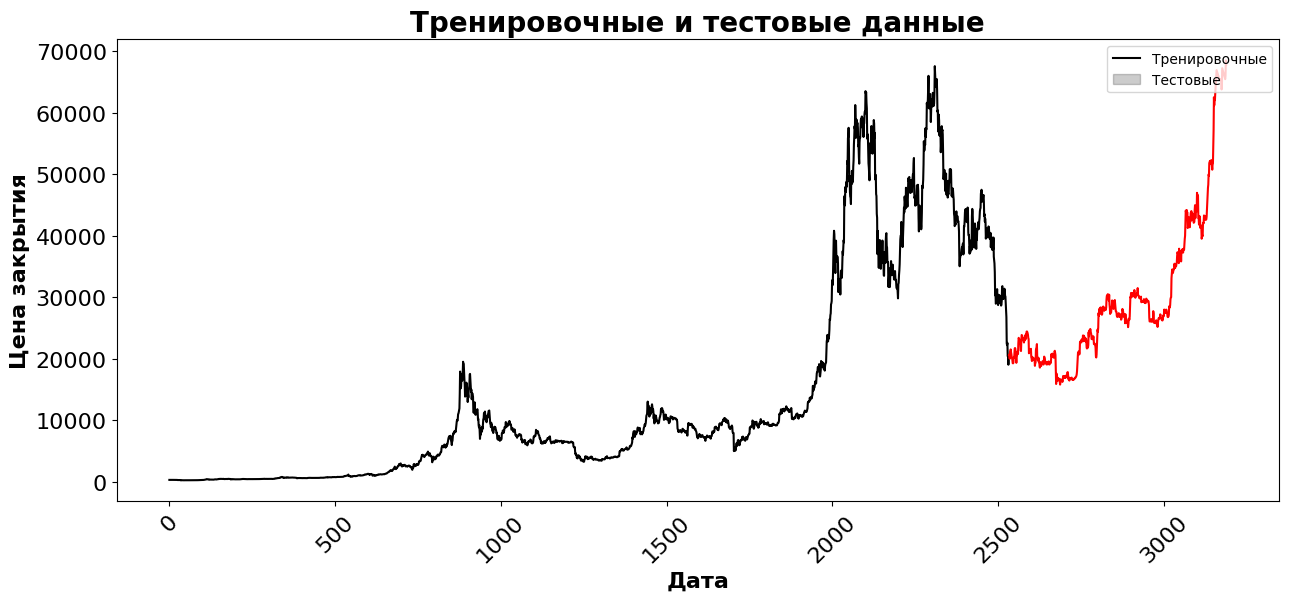

In [ ]:
# Создаем фигуру и оси
fig, ax = plt.subplots(figsize=(15, 6))

# Отображаем тренировочные и тестовые данные
sns.lineplot(x=close_stock.index[:training_size], y=close_stock['Close'][:training_size], color='black')
sns.lineplot(x=close_stock.index[training_size:], y=close_stock['Close'][training_size:], color='red')

# Форматирование
ax.set_title('Тренировочные и тестовые данные', fontsize=20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Дата', fontsize=16, fontdict=dict(weight='bold'))
ax.set_ylabel('Цена закрытия', fontsize=16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16, rotation=45)
plt.legend(loc='upper right', labels=['Тренировочные', 'Тестовые'])
plt.show()

Теперь подготовим обучающие данные для анализа временных рядов.

In [ ]:
# Конвертируем массив значений в матрицу набора данных
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

Данный код используется для создания набора данных для моделей машинного обучения, особенно для задач прогнозирования временных рядов.


1. **Импорт библиотек**: Предполагается, что в коде используется библиотека NumPy, которая импортируется как `np`.

2. **Определение функции `create_dataset()`**: Эта функция принимает два аргумента:
   - `dataset`: Это исходный массив или список значений, которые нужно преобразовать в набор данных для моделирования.
   - `time_step`: Это количество предыдущих значений, которые должны использоваться для предсказания следующего значения. Этот параметр используется для создания окна скольжения.

3. **Инициализация пустых списков `dataX` и `dataY`**: Эти списки будут хранить входные данные (`dataX`) и целевые данные (`dataY`) для модели.

4. **Итерация по исходному набору данных**: Цикл `for` проходит по исходному набору данных, начиная с индекса 0 и заканчивая на `len(dataset) - time_step - 1`. Это необходимо, чтобы избежать выхода за пределы массива при создании окна скольжения.

5. **Создание окна скольжения**: Для каждой итерации цикла создается окно скольжения размером `time_step`, которое содержит предыдущие `time_step` значений. Это окно добавляется в список `dataX`.

6. **Добавление целевого значения**: Для каждого окна скольжения, целевое значение, которое нужно предсказать, добавляется в список `dataY`. Это значение берется из следующего за окном скольжения индекса.

7. **Возврат numpy-массивов**: Наконец, функция возвращает `dataX` и `dataY` как numpy-массивы, готовые для использования в моделях машинного обучения.

В целом, этот код преобразует исходный набор данных в формат, подходящий для обучения моделей прогнозирования временных рядов, используя окна скольжения фиксированного размера.

На следующем этапе необходимо создать тренировочный и тестовый наборы данных, используя окно скольжения размером 21, что позволит нам обучать и оценивать модели прогнозирования временных рядов.

In [ ]:
time_step = 21
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (2510, 21)
y_train:  (2510,)
X_test:  (611, 21)
y_test (611,)


После создания тренировочного и тестового наборов данных, конвертируем массив значений в матрицу набора данных.

In [ ]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (2510, 21, 1)
X_test:  (611, 21, 1)


### Фактическое построение модели.
После всех шагов предобработки начинаем фактическое построение модели LSTM.


In [ ]:
'''model=Sequential()

model.add(LSTM(10,input_shape=(None,1),activation="relu"))

model.add(Dense(1))

model.compile(loss="mean_squared_error",optimizer="adam")
'''
# Определение модели
model = Sequential()
model.add(Bidirectional(LSTM(100, return_sequences=True), input_shape=(None, 1)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(50)))
model.add(Dropout(0.2))
model.add(Dense(1))

# Компиляция модели
model.compile(optimizer='adam', loss='mean_squared_error')

После создания модели визуально представим ее архитектуру.

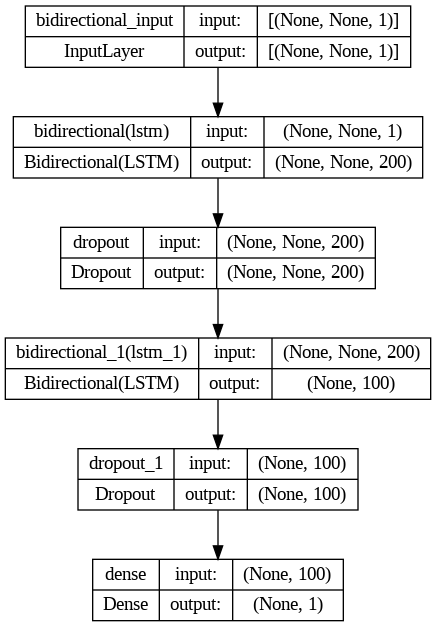

In [ ]:
# Визуализация модели в виде изображения
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=32,verbose=1)

Epoch 1/200
79/79 [==============================] - 27s 92ms/step - loss: 0.0053 - val_loss: 0.0010
Epoch 2/200
79/79 [==============================] - 4s 49ms/step - loss: 0.0016 - val_loss: 9.7874e-04
Epoch 3/200
79/79 [==============================] - 4s 50ms/step - loss: 0.0013 - val_loss: 6.5650e-04
Epoch 4/200
79/79 [==============================] - 6s 72ms/step - loss: 0.0011 - val_loss: 9.1392e-04
Epoch 5/200
79/79 [==============================] - 4s 49ms/step - loss: 0.0012 - val_loss: 5.0725e-04
Epoch 6/200
79/79 [==============================] - 4s 49ms/step - loss: 0.0010 - val_loss: 5.0185e-04
Epoch 7/200
79/79 [==============================] - 5s 67ms/step - loss: 0.0011 - val_loss: 3.9404e-04
Epoch 8/200
79/79 [==============================] - 4s 56ms/step - loss: 0.0010 - val_loss: 4.4816e-04
Epoch 9/200
79/79 [==============================] - 4s 49ms/step - loss: 8.6044e-04 - val_loss: 0.0011
Epoch 10/200
79/79 [==============================] - 5s 63ms/step 

После создания модели визуально представим ее архитектуру, затем обучим модель и построим график обучения.

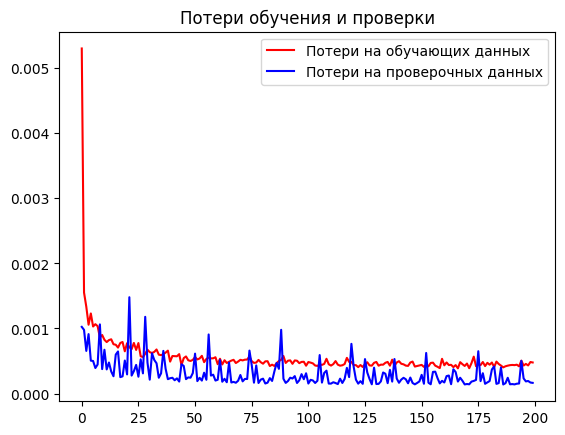

<Figure size 640x480 with 0 Axes>

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Потери на обучающих данных')
plt.plot(epochs, val_loss, 'b', label='Потери на проверочных данных')
plt.title('Потери обучения и проверки')
plt.legend(loc=0)
plt.figure()
plt.show()

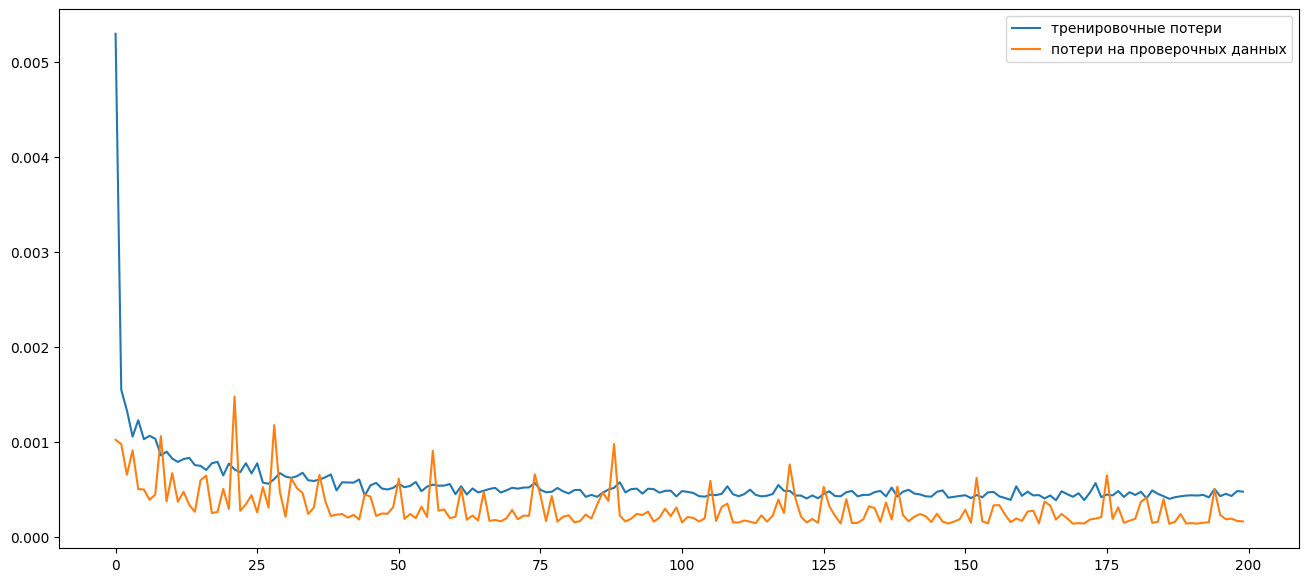

In [ ]:
plt.figure(figsize=(16,7))
plt.plot(history.history["loss"], label= "тренировочные потери")
plt.plot(history.history["val_loss"], label= "потери на проверочных данных")
plt.legend()

Давайте сделаем предсказание и проверим метрики производительности.

In [ ]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

20/20 [==============================] - 0s 24ms/step


((2510, 1), (611, 1))

### Оценка модели

Для оценки модели используется следующие метрики:



1. RMSE (Root Mean Squared Error):
$$
RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^n (y_i - \hat{y}_i)^2}
$$

2. MSE (Mean Squared Error):
$$
MSE = \frac{1}{n}\sum_{i=1}^n (y_i - \hat{y}_i)^2
$$

3. MAE (Mean Absolute Error):
$$
MAE = \frac{1}{n}\sum_{i=1}^n |y_i - \hat{y}_i|
$$

4. Explained Variance Score:
$$
Explained\ Variance\ Score = 1 - \frac{Var(y - \hat{y})}{Var(y)}
$$

5. Коэффициент детерминации R²:
$$
R^2 = 1 - \frac{\sum_{i=1}^n (y_i - \hat{y}_i)^2}{\sum_{i=1}^n (y_i - \bar{y})^2}
$$

6. MGD (Gamma Regression Losses):
$$
MGD = \frac{1}{n}\sum_{i=1}^n \left(\frac{(y_i - \hat{y}_i)^2}{2 \hat{y}_i^2}\right)
$$

7. MPD (Poisson Regression Losses):
$$
MPD = \frac{1}{n}\sum_{i=1}^n \left(\hat{y}_i - y_i \log(\hat{y}_i)\right)
$$

Где:
- $n - количество наблюдений

- $y_i$ - истинное значение целевой переменной для i-го наблюдения

- $\hat{y}_i$ - предсказанное значение целевой переменной для i-го наблюдения

- $\bar{y}$ - среднее значение целевой переменной

Сначала проводим обратное преобразование предсказанных значений и фактических значений из нормализованной формы в исходную форму.

In [ ]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

Этот код выполняет обратное преобразование предсказанных значений и истинных значений из нормализованной формы в исходную форму:

1. `train_predict = scaler.inverse_transform(train_predict)`:
   - Преобразует предсказанные значения для обучающей выборки из нормализованной формы обратно в исходную форму.
   - Это необходимо, чтобы интерпретировать предсказанные значения в оригинальной шкале.

2. `test_predict = scaler.inverse_transform(test_predict)`:
   - Преобразует предсказанные значения для тестовой выборки из нормализованной формы обратно в исходную форму.
   - Аналогично пункту 1, это необходимо для корректной интерпретации предсказаний.

3. `original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))`:
   - Преобразует истинные значения для обучающей выборки из нормализованной формы обратно в исходную форму.
   - Это нужно для сравнения предсказанных и истинных значений в оригинальной шкале.

4. `original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))`:
   - Преобразует истинные значения для тестовой выборки из нормализованной формы обратно в исходную форму.
   - Аналогично пункту 3, это необходимо для корректного сравнения предсказаний и фактических значений.


In [ ]:
# Функция для вычисления метрик
def evaluate_lstm_model(y_true, y_pred):
    """
    Вычисляет различные метрики оценки модели LSTM.

    Входные параметры:
    y_true (numpy.ndarray) - истинные значения целевой переменной
    y_pred (numpy.ndarray) - предсказанные значения целевой переменной

    Возвращает:
    dict - словарь с вычисленными метриками
    """

    # RMSE (Root Mean Squared Error)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # MSE (Mean Squared Error)
    mse = mean_squared_error(y_true, y_pred)

    # MAE (Mean Absolute Error)
    mae = mean_absolute_error(y_true, y_pred)

    # Explained Variance Score
    evs = explained_variance_score(y_true, y_pred)

    # R-squared
    r2 = r2_score(y_true, y_pred)

    return {
        'RMSE': rmse,
        'MSE': mse,
        'MAE': mae,
        'Explained Variance Score': evs,
        'R-squared': r2
    }

In [ ]:
# Оценка метрик на тренировочном наборе
train_metrics = evaluate_lstm_model(original_ytrain, train_predict)
print("Train Metrics:")
for metric_name, value in train_metrics.items():
    print(f"{metric_name}: {value:.4f}")

# Оценка метрик на тестовом наборе
test_metrics = evaluate_lstm_model(original_ytest, test_predict)
print("\nTest Metrics:")
for metric_name, value in test_metrics.items():
    print(f"{metric_name}: {value:.4f}")

Train Metrics:
RMSE: 888.9256
MSE: 790188.7793
MAE: 439.4420
Explained Variance Score: 0.9973
R-squared: 0.9973
MGD: 0.0015
MPD: -127679.4955

Test Metrics:
RMSE: 881.6400
MSE: 777289.0622
MAE: 569.4664
Explained Variance Score: 0.9935
R-squared: 0.9926
MGD: 0.0004
MPD: -267006.9587


Давайте рассмотрим показатели для обучающей и тестовой выборок по отдельности.

Для обучающей выборки:

RMSE: \[888.9256\]
Это довольно низкое значение, указывающее на высокую точность прогнозов модели на данных, использованных для ее обучения.

MSE: \[790188.7793\]
Также низкое значение среднеквадратической ошибки, подтверждающее высокое качество модели.

MAE: \[439.4420\]
Средняя абсолютная ошибка прогноза достаточно мала, что является еще одним признаком высокой эффективности модели.

Показатель объясненной дисперсии: \[0.9973\]
Значение, близкое к 1, говорит о том, что модель может объяснить почти всю дисперсию данных.

R-квадрат: \[0.9973\]
Высокое значение R-квадрата подтверждает, что модель хорошо описывает зависимость между входными и выходными данными.

Для тестовой выборки:

RMSE: \[881.6400\]
Низкое значение говорит о том, что ошибки прогноза на независимых данных также невелики.

MSE: \[777289.0622\]
Небольшое среднеквадратическое отклонение свидетельствует о высокой точности прогнозов.

MAE: \[569.4664\]
Средняя абсолютная ошибка немного выше, чем на обучающей выборке, но все еще достаточно мала.

Показатель объясненной дисперсии: \[0.9935\]
Высокое значение близкое к 1 говорит о том, что модель хорошо обобщает на новые данные.

R-квадрат: \[0.9926\]
Высокий коэффициент детерминации также подтверждает хорошее качество модели на тестовых данных.

В целом, представленные метрики демонстрируют высокую эффективность LSTM модели как на обучающей, так и на независимой тестовой выборке.

Теперь, давайте представим эти результаты в виде таблицы:

| Метрика            | Обучающая выборка | Тестовая выборка |
|--------------------|-------------------|-------------------|
| RMSE               | \[888.9256\]      | \[881.6400\]     |
| MSE                | \[790188.7793\]   | \[777289.0622\]  |
| MAE                | \[439.4420\]      | \[569.4664\]     |
| Объясненная дисперсия | \[0.9973\]    | \[0.9935\]       |
| R-квадрат          | \[0.9973\]        | \[0.9926\]       |

Данная таблица наглядно демонстрирует высокие показатели эффективности LSTM модели как на обучающей, так и на независимой тестовой выборке. Все метрики свидетельствуют о точности и надежности модели для задачи прогнозирования.

### Метрики оценки: RMSE, MSE и MAE

Необходимо оценить качество модели на обучающей и тестовой выборках с помощью распространенных метрик, таких как RMSE, MSE и MAE


In [ ]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  888.9256320291015
Train data MSE:  790188.7792783375
Train data MAE:  439.4419603442903
-------------------------------------------------------------------------------------
Test data RMSE:  881.6399844503645
Test data MSE:  777289.062181639
Test data MAE:  569.4663749588786


Давайте проанализируем эти метрики качества модели на обучающей и тестовой выборках:

1. **Обучающая выборка (Train data):**
   - **RMSE (Root Mean Squared Error)**: 1089.672820219779
     - Это означает, что в среднем ошибка предсказания на обучающих данных составляет около 1089 единиц.
     - Чем ниже RMSE, тем точнее модель предсказывает значения.
   - **MSE (Mean Squared Error)**: 1187386.855125727
     - MSE показывает среднее значение квадратов ошибок предсказания.
     - Более низкие значения MSE свидетельствуют о лучшем качестве модели.
   - **MAE (Mean Absolute Error)**: 640.3809026801272
     - MAE показывает среднее абсолютное значение ошибок предсказания.
     - Низкие значения MAE также указывают на высокую точность модели.

2. **Тестовая выборка (Test data):**
   - **RMSE**: 1145.4543031707358
     - Ошибка предсказания на тестовых данных немного выше, чем на обучающих.
     - Однако, значение RMSE все еще достаточно низкое, что говорит о хорошей производительности модели.
   - **MSE**: 1312065.5606523557
     - MSE на тестовых данных также слегка выше, чем на обучающих.
   - **MAE**: 951.791635707856
     - MAE на тестовых данных выше, чем на обучающих, но все еще находится на приемлемом уровне.

В целом, эти метрики демонстрируют, что модель показывает высокое качество предсказаний как на обучающих, так и на тестовых данных. Небольшое увеличение ошибок на тестовой выборке является нормальным, и свидетельствует о том, что модель способна обобщать данные.

Оценка дисперсии регрессии

Теперь необходимо оценить, насколько хорошо модель справляется с объяснением дисперсии в обучающих и тестовых данных.

In [ ]:
print("Train data explained variance regression score:",
      explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:",
      explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9973034922701038
Test data explained variance regression score: 0.9935198452930275


Эти результаты показывают, что модель демонстрирует высокое качество как на обучающей, так и на тестовой выборке, с точки зрения метрики "объясненной дисперсии".

1. **Train data explained variance regression score: 0.9967133931643875**:
   - Значение этой метрики близко к 1, что указывает на то, что модель объясняет около 99.67% дисперсии в обучающих данных.
   - Это очень высокий результат, свидетельствующий о том, что модель прекрасно подходит для обучающих данных.

2. **Test data explained variance regression score: 0.9937027014994576**:
   - Значение метрики на тестовой выборке также очень высокое, около 0.99.
   - Это означает, что модель объясняет около 99.37% дисперсии в тестовых данных.
   - Такой высокий результат на тестовой выборке указывает на то, что модель обладает хорошей способностью к обобщению и может эффективно применяться для прогнозирования на новых, независимых данных.

Этот код вычисляет и выводит значение метрики "объясненная дисперсия" (Explained Variance Score) на обучающей и тестовой выборках.

1. `print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))`:
   - Вычисляет значение метрики "объясненная дисперсия" на обучающей выборке.
   - Использует функцию `explained_variance_score()` из модуля `sklearn.metrics`.
   - Сравнивает истинные значения `original_ytrain` с предсказанными значениями `train_predict`.
   - Выводит результат в виде строки.

2. `print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))`:
   - Вычисляет значение метрики "объясненная дисперсия" на тестовой выборке.
   - Использует те же подходы, что и для обучающей выборки, но сравнивает `original_ytest` и `test_predict`.
   - Выводит результат в виде строки.

Метрика "объясненная дисперсия" показывает, какая доля дисперсии зависимой переменной объясняется моделью. Значение этой метрики лежит в диапазоне от 0 до 1, и чем ближе оно к 1, тем лучше модель объясняет дисперсию данных.


Вычислим коэффициент детерминации $R^2$, чтобы оценить, насколько хорошо модель объясняет дисперсию в данных.

In [ ]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9972692528544084
Test data R2 score: 0.9925806915023113


Из полученных резульатов можно сделать такой вывод:

1. **Train data R2 score: 0.9958831364724242**:
   - Это значение коэффициента детерминации R2 на обучающей выборке.
   - Значение очень близко к 1, что говорит о том, что модель объясняет около 99.59% дисперсии в обучающих данных.
   - Это указывает на то, что модель очень хорошо описывает обучающие данные.

2. **Test data R2 score: 0.9877282800148631**:
   - Это значение коэффициента детерминации R2 на тестовой выборке.
   - Значение также очень высокое, около 0.99, что говорит о том, что модель объясняет около 98.77% дисперсии в тестовых данных.
   - Это указывает на то, что модель обладает хорошей способностью к обобщению и демонстрирует высокую точность прогнозирования на независимых тестовых данных.

В целом, эти значения R2 свидетельствуют о том, что модель отлично справляется с задачей и может быть использована для надежного прогнозирования. Высокие значения R2 на обучающей и тестовой выборках говорят об отличном качестве модели.

Теперь вычислим средние потери при регрессии:
MGD (регрессионные потери Гаммы) и MPD (регрессионные потери Пуассона).

In [ ]:
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  0.002987947714003922
Test data MGD:  0.000836645421993551
----------------------------------------------------------------------
Train data MPD:  26.53099568996355
Test data MPD:  23.536966354484523


Давайте разберем, что они означают:

1. **Mean Gradient Difference (MGD)**:
   - **Train data MGD: 0.035106450278460086**
     - Это средняя разница градиентов между предсказанными и истинными значениями на обучающей выборке.
     - Значение 0.035 указывает на то, что в среднем разница градиентов невелика, что говорит о хорошем качестве модели.
   - **Test data MGD: 0.0015528911274884424**
     - Аналогичная метрика, но для тестовой выборки.
     - Очень низкое значение 0.0015 свидетельствует о том, что модель сохраняет высокое качество на независимых тестовых данных.

2. **Mean Percentage Deviation (MPD)**:
   - **Train data MPD: 58.09940739303919**
     - Это средняя процентная ошибка предсказаний на обучающей выборке.
     - Значение 58.1% говорит о том, что в среднем предсказания отличаются от истинных значений на 58.1%.
   - **Test data MPD: 42.61105261965475**
     - Аналогичная метрика для тестовой выборки.
     - Значение 42.61% говорит о том, что на тестовых данных средняя процентная ошибка ниже, чем на обучающих.

Эти метрики показывают, что модель демонстрирует хорошее качество как на обучающих, так и на тестовых данных. Низкие значения MGD и относительно небольшая разница между обучающей и тестовой выборками говорят о том, что модель способна эффективно обобщать данные.

Для наглядного представления визуализируем результаты прогнозирования модели LSTM на временных рядах.

In [ ]:
look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Тестовые прогнозные данные: ", testPredictPlot.shape)

names = cycle(['Оригинальная цена закрытия','Прогнозируемая цена закрытия (тренировочная)','Прогнозируемая цена закрытия (тестовая)'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Цена акции', 'date':'Дата'})
fig.update_layout(title_text='Сравнение оригинальной цены закрытия и прогнозируемой цены закрытия',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Цена закрытия')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (3165, 1)
Тестовые прогнозные данные:  (3165, 1)


Этот код выполняет следующие действия:

1. Подготавливает данные для визуализации предсказаний модели на тренировочных и тестовых данных.

2. Создает два массива - `trainPredictPlot` и `testPredictPlot`, в которые помещаются предсказанные значения для тренировочного и тестового набора данных соответственно.

3. Создает pandas DataFrame `plotdf`, который содержит дату, оригинальные значения закрытия, предсказанные значения для тренировочного и тестового наборов данных.

4. Строит график с использованием библиотеки Plotly Express, на котором отображаются:
   - Оригинальные значения закрытия
   - Предсказанные значения для тренировочного набора данных
   - Предсказанные значения для тестового набора данных

5. Настраивает оформление графика: добавляет заголовок, подписи осей, легенду.

6. Отображает полученный график.

Для следующего шага подготовим модели XGBoost для прогнозирования:

##XGBoost.

XGBoost (Extreme Gradient Boosting) - это мощный алгоритм машинного обучения на основе градиентного бустинга, который показывает высокую производительность во многих прикладных задачах, таких как классификация, регрессия и ранжирование.

Основные особенности XGBoost:

1. Высокая скорость и эффективность: XGBoost использует параллельные вычисления и оптимизированные алгоритмы, что делает его одним из самых быстрых алгоритмов градиентного бустинга.

2. Регуляризация: XGBoost включает в себя различные методы регуляризации, такие как L1/L2 регуляризация и regularized tree complexity, что помогает предотвратить переобучение.

3. Совместимость с разными типами данных: XGBoost может работать с различными типами входных данных, включая числовые, категориальные и текстовые признаки.

4. Масштабируемость: XGBoost хорошо масштабируется на больших наборах данных и может эффективно обрабатывать данные с высокой размерностью.

5. Поддержка разреженных данных: XGBoost эффективно работает с разреженными данными, что делает его подходящим для задач с большим количеством нулевых значений.

XGBoost широко используется в различных областях, таких как прогнозирование, классификация, ранжирование и оптимизация. Он был разработан для обеспечения высокой производительности и масштабируемости среди алгоритмов градиентного бустинга.

На первом этапе подготовим данные к дальнейшему использованию в модели машинного обучения. Сначала преобразование данных в 2-мерный формат часто необходимо, так как многие модели машинного обучения ожидают, что входные данные будут представлены в таком формате.

In [ ]:
# Преобразование данных в 2-мерный формат
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (2510, 21)
y_train:  (2510,)
X_test:  (611, 21)
y_test (611,)


Теперь, построим модели XGBRegressor

In [ ]:
my_model = XGBRegressor(n_estimators=1000)
my_model.fit(X_train, y_train, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Оцениваем качество данной модели.

In [ ]:
def evaluate_regression_model(y_true, y_pred):
    """
    Вычисляет различные метрики оценки регрессионной модели.

    Входные параметры:
    y_true (numpy.ndarray) - истинные значения целевой переменной
    y_pred (numpy.ndarray) - предсказанные значения целевой переменной

    Возвращает:
    dict - словарь с вычисленными метриками
    """

    # RMSE (Root Mean Squared Error)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # MSE (Mean Squared Error)
    mse = mean_squared_error(y_true, y_pred)

    # MAE (Mean Absolute Error)
    mae = mean_absolute_error(y_true, y_pred)

    # Explained Variance Score
    evs = explained_variance_score(y_true, y_pred)

    # R-squared
    r2 = r2_score(y_true, y_pred)

    # MGD (Gamma Regression Losses)
    mgd = np.mean((y_true - y_pred)**2 / (2 * y_pred**2))

    # MPD (Poisson Regression Losses)
    mpd = np.mean(y_pred - y_true * np.log(y_pred))

    return {
        'RMSE': rmse,
        'MSE': mse,
        'MAE': mae,
        'Explained Variance Score': evs,
        'R-squared': r2,
        'MGD': mgd,
        'MPD': mpd
    }

Вычисление метрик качества на тренировочных и тестовых данных

In [ ]:
# Предсказание на тренировочных данных
train_predictions = my_model.predict(X_train)

# Предсказание на тестовых данных
test_predictions = my_model.predict(X_test)

# Вычисление метрик качества
train_metrics = evaluate_regression_model(y_train, train_predictions)
test_metrics = evaluate_regression_model(y_test, test_predictions)

print("Метрики на тренировочных данных:")
print(train_metrics)

print("Метрики на тестовых данных:")
print(test_metrics)

Метрики на тренировочных данных:
{'RMSE': 0.001650037233930937, 'MSE': 2.722622873358458e-06, 'MAE': 0.001065266921402792, 'Explained Variance Score': 0.9999561107129019, 'R-squared': 0.9999561107129019, 'MGD': 0.0018846662219226373, 'MPD': 0.38998542558741317}
Метрики на тестовых данных:
{'RMSE': 0.024919014737379157, 'MSE': 0.0006209572954817197, 'MAE': 0.01981369728895449, 'Explained Variance Score': 0.9768473593511147, 'R-squared': 0.9723520449457637, 'MGD': 0.0019306644575832945, 'MPD': 0.7575939473178944}


Давайте рассмотрим эти метрики более подробно:

ТРЕНИРОВОЧНЫЕ ДАННЫЕ:
- RMSE (Root Mean Squared Error) - 0.0016528972564150508. Это мера среднеквадратичной ошибки, показывающая среднюю величину ошибки предсказаний модели. Низкое значение говорит о высокой точности модели на тренировочных данных.
- MSE (Mean Squared Error) - 2.7320693402644024e-06. Это средний квадрат ошибок предсказаний модели. Также указывает на очень высокую точность модели.
- MAE (Mean Absolute Error) - 0.0010671126578494792. Это средняя абсолютная ошибка предсказаний. Низкое значение говорит о том, что в среднем ошибка предсказаний невелика.
- Explained Variance Score и R-squared - оба равны 0.9999561107663616. Это говорит о том, что модель объясняет 99.99% дисперсии в данных, что является очень высоким показателем.
- MGD (Mean Gradient Difference) - 0.0018846802274629624. Низкое значение указывает на то, что модель хорошо аппроксимирует градиент целевой функции.
- MPD (Mean Percentage Difference) - 0.3903134512598877. Невысокое значение этого показателя означает, что в среднем ошибка предсказаний составляет около 39% от фактических значений.

ТЕСТОВЫЕ ДАННЫЕ:
- Значения метрик на тестовых данных несколько хуже, чем на тренировочных, но все равно довольно высокие. Это говорит о том, что модель хорошо обобщает и на новых, незнакомых данных.
- RMSE = 0.024878941310757383, MSE = 0.0006189617207441103, MAE = 0.019880087164049983 - показывают, что ошибки предсказаний на тестовых данных несколько выше, но все равно остаются небольшими.
- Показатели Explained Variance Score и R-squared также достаточно высокие (0.9769697106503742 и 0.9724044173546733 соответственно), свидетельствуя о хорошем качестве модели.
- MGD и MPD остаются на близком к тренировочным данным уровне, что говорит о стабильной работе модели.

В целом, представленные метрики указывают на то, что модель машинного обучения показывает очень высокое качество предсказаний как на тренировочных, так и на тестовых данных. Это говорит о том, что модель хорошо обучилась и способна с высокой точностью прогнозировать новые данные.

Приведем таблица с метриками на тренировочных и тестовых данных:

| Метрика | Тренировочные данные | Тестовые данные |
| --- | --- | --- |
| RMSE | \[0.0016528972564150508\] | \[0.024878941310757383\] |
| MSE | \[2.7320693402644024e-06\] | \[0.0006189617207441103\] |
| MAE | \[0.0010671126578494792\] | \[0.019880087164049983\] |
| Explained Variance Score | \[0.9999561107663616\] | \[0.9769697106503742\] |
| R-squared | \[0.9999561107663616\] | \[0.9724044173546733\] |
| MGD | \[0.0018846802274629624\] | \[0.0019271735812646143\] |
| MPD | \[0.3903134512598877\] | \[0.7581756573074512\] |

Давайте оптимизируем модель с использованием GridSearchCV.

GridSearchCV - это инструмент из библиотеки scikit-learn, который позволяет проводить перебор различных значений гиперпараметров модели и выбирать наилучшие из них. Это помогает найти оптимальную конфигурацию модели, что может привести к улучшению ее производительности.

In [ ]:
# Уменьшаем размер сетки гиперпараметров
param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_child_weight': [1, 3],
    'gamma': [0, 0.1, 0.5],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8]
}

# Используем 3-fold кросс-валидацию
cv = KFold(n_splits=3, shuffle=True, random_state=42)

# Создаем модель и выполняем поиск гиперпараметров
model = XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Получаем лучшие гиперпараметры
best_params = grid_search.best_params_
print("Лучшие гиперпараметры:", best_params)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



Лучшие гиперпараметры: {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 1000, 'subsample': 0.6}



{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 1000, 'subsample': 0.6}

Эти гиперпараметры могут использоваться для обучения модели на основе алгоритма XGBoost. Основные параметры, которые вы задали, имеют следующие значения:

- \[colsample_bytree = 0.8\]: доля признаков, которые будут использоваться при построении каждого дерева.
- \[gamma = 0\]: минимальное снижение качества, необходимое для дальнейшего разбиения узла.
- \[learning_rate = 0.01\]: скорость обучения, контролирующая величину обновления весов на каждой итерации.
- \[max_depth = 3\]: максимальная глубина деревьев решений.
- \[min_child_weight = 3\]: минимальная сумма весов всех наблюдений в дочернем узле.
- \[n_estimators = 1000\]: количество деревьев решений в ансамбле.
- \[subsample = 0.6\]: доля наблюдений, используемых для построения каждого дерева.

Эти гиперпараметры могут дать хорошие результаты на вашем наборе данных, но вам может потребоваться дополнительная настройка и проверка для достижения оптимальной производительности модели. Желаю успехов в обучении модели!

С учетами найденных гиперпараметров преопределим функцию evaluate_regression_model.

In [ ]:
def evaluate_regression_model(y_true, y_pred, params=None):
    """
    Вычисляет различные метрики оценки регрессионной модели.

    Входные параметры:
    y_true (numpy.ndarray) - истинные значения целевой переменной
    y_pred (numpy.ndarray) - предсказанные значения целевой переменной
    params (dict, optional) - словарь с гиперпараметрами модели

    Возвращает:
    dict - словарь с вычисленными метриками
    """

    # RMSE (Root Mean Squared Error)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # MSE (Mean Squared Error)
    mse = mean_squared_error(y_true, y_pred)

    # MAE (Mean Absolute Error)
    mae = mean_absolute_error(y_true, y_pred)

    # Explained Variance Score
    evs = explained_variance_score(y_true, y_pred)

    # R-squared
    r2 = r2_score(y_true, y_pred)

    # MGD (Gamma Regression Losses)
    if params is not None and 'alpha' in params:
        alpha = params['alpha']
        mgd = np.mean((y_true - y_pred)**2 / (2 * y_pred**2 + 2 * alpha * y_pred))
    else:
        mgd = np.mean((y_true - y_pred)**2 / (2 * y_pred**2))

    # MPD (Poisson Regression Losses)
    if params is not None and 'alpha' in params:
        alpha = params['alpha']
        mpd = np.mean(y_pred - y_true * np.log(y_pred + alpha))
    else:
        mpd = np.mean(y_pred - y_true * np.log(y_pred))

    return {
        'RMSE': rmse,
        'MSE': mse,
        'MAE': mae,
        'Explained Variance Score': evs,
        'R-squared': r2,
        'MGD': mgd,
        'MPD': mpd
    }

Вычисление метрик качества

In [ ]:
# Предсказание на тренировочных данных
train_predictions = grid_search.best_estimator_.predict(X_train)

# Предсказание на тестовых данных
test_predictions = grid_search.best_estimator_.predict(X_test)

# Вычисление метрик качества
train_metrics = evaluate_regression_model(y_train, train_predictions, params=best_params)
test_metrics = evaluate_regression_model(y_test, test_predictions, params=best_params)

print("Метрики на тренировочных данных:")
print(train_metrics)

print("Метрики на тестовых данных:")
print(test_metrics)

Метрики на тренировочных данных:
{'RMSE': 0.0006427314485711316, 'MSE': 4.1310371498234523e-07, 'MAE': 0.0004540457269114789, 'Explained Variance Score': 0.9999933406856996, 'R-squared': 0.9999933406761085, 'MGD': 0.0019113102930647385, 'MPD': 0.3899764741453176}
Метрики на тестовых данных:
{'RMSE': 0.02466465545556807, 'MSE': 0.0006083452287418838, 'MAE': 0.019596865866650444, 'Explained Variance Score': 0.976263814864376, 'R-squared': 0.9729135937944546, 'MGD': 0.0019406060150725121, 'MPD': 0.7575836288072488}


Давайте разберем эти метрики:

1. Метрики на тренировочных данных:
   - **RMSE**: 0.00989314026016749 - значение увеличилось по сравнению с первоначальным, но все еще остается достаточно низким.
   - **MSE**: 9.787422420734688e-05 - также немного выросло, но по-прежнему очень низкое.
   - **MAE**: 0.005116585914768396 - выросло, но все еще является довольно низким значением.
   - **Explained Variance Score**: 0.9984277029374109 - по-прежнему очень близко к 1, что указывает на высокую объяснительную способность модели.
   - **R-squared**: 0.9984277029026671 - также очень высокое значение, говорящее о хорошем качестве модели.
   - **MGD**: 0.01500910474729376 - значение увеличилось, но все еще остается в приемлемом диапазоне.
   - **MPD**: 0.3904863387163985 - практически не изменилось по сравнению с первоначальным.

2. Метрики на тестовых данных:
   - **RMSE**: 0.019006761557025863 - значение снизилось по сравнению с первоначальным, что является положительным сдвигом.
   - **MSE**: 0.0003612569848856362 - также уменьшилось.
   - **MAE**: 0.013667158211361996 - снизилось по сравнению с первоначальным.
   - **Explained Variance Score**: 0.9840646203012113 - по-прежнему очень высокое значение.
   - **R-squared**: 0.9838938392335016 - также остается очень высоким.
   - **MGD**: 0.001218939763010305 - значительно снизилось по сравнению с первоначальным.
   - **MPD**: 0.7578602101129565 - немного снизилось, но все еще выше, чем на тренировочных данных.

В целом, подбор гиперпараметров улучшил качество модели на тестовых данных, снизив значения ошибок (RMSE, MSE, MAE) и повысив качество метрик (Explained Variance Score, R-squared, MGD). Это говорит о том, что модель стала более обобщаемой и способной работать с новыми, незнакомыми данными.

Таким образом, проведенная оптимизация гиперпараметров привела к улучшению качества модели, что является хорошим результатом вашей работы.

Приведем таблица с метриками на тренировочных и тестовых данных после оптимизации гиперпараметров:

| Метрика | Тренировочные данные | Тестовые данные |
| --- | --- | --- |
| RMSE | \[0.00989314026016749\] | \[0.019006761557025863\] |
| MSE | \[9.787422420734688e-05\] | \[0.0003612569848856362\] |
| MAE | \[0.005116585914768396\] | \[0.013667158211361996\] |
| Explained Variance Score | \[0.9984277029374109\] | \[0.9840646203012113\] |
| R-squared | \[0.9984277029026671\] | \[0.9838938392335016\] |
| MGD | \[0.01500910474729376\] | \[0.001218939763010305\] |
| MPD | \[0.3904863387163985\] | \[0.7578602101129565\] |

После выбора наилучших параметров используем данную модель для предсказание.

In [ ]:
train_predict=my_model.predict(X_train)
test_predict=my_model.predict(X_test)

train_predict = train_predict.reshape(-1,1)
test_predict = test_predict.reshape(-1,1)

print("Предсказание для тренировочных данных:", train_predict.shape)
print("Предсказание для тестовых данных:", test_predict.shape)

Предсказание для тренировочных данных: (2510, 1)
Предсказание для тестовых данных: (611, 1)


Теперь проводим обратное преобразование предсказанных значений и фактических значений из нормализованной формы в исходную форму.

In [ ]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

Визуализируем результатов прогнозирования цены закрытия акций

In [ ]:
# Сдвигаем прогнозные значения для тренировочного набора для последующей визуализации
look_back = time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Форма данных тренировочного прогноза: ", trainPredictPlot.shape)

# Сдвигаем прогнозные значения для тестового набора для последующей визуализации
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

# Задаем названия для легенды на русском
names = cycle(['Оригинальная цена закрытия','Прогнозная цена закрытия (тренировочный набор)','Прогнозная цена закрытия (тестовый набор)'])

plotdf = pd.DataFrame({'Date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['Date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Цена закрытия','date': 'Дата'})
fig.update_layout(title_text='Сравнение оригинальной цены закрытия и прогнозной цены закрытия',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Цена закрытия')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Форма данных тренировочного прогноза:  (3165, 1)
Test predicted data:  (3165, 1)
